In [1]:
import requests
import gzip
import pandas as pd
import networkx as nx
import numpy as np

%matplotlib inline
import seaborn as sns

import sys
sys.path = ['/cellar/users/mikeyu/DeepTranslate/ddot'] + sys.path

import ddot
from ddot import Ontology, get_gene_name_converter, parse_gaf, parse_obo, nx_to_NdexGraph, read_term_descriptions, ndex_to_sim_matrix
from ddot import expand_seed, melt_square, make_index, align_hierarchies, update_nx_with_alignment, parse_ndex_uuid
from ddot.utils import NdexGraph_to_nx
from ddot.utils import bubble_layout_nx

# Setup parameters

In [2]:
alpha = 0.1
beta = 0.5

In [3]:
similarity_uuid = 'd2dfa5cc-56de-11e7-a2e2-0660b7976219'
# similarity_uuid = '5a88022f-53dd-11e7-a2e2-0660b7976219'

go_uuid = '8bfa8318-55ed-11e7-a2e2-0660b7976219'

In [4]:
ndex_server = 'http://test.ndexbio.org'
ndex_user = 'mikeyu_testacct2'
ndex_pass = 'GoHejVeg8'

In [5]:
seed = ['FANCA','FANCB', 'FANCC', 'BRCA2', 'FANCD2', 'FANCE',
        'FANCF', 'FANCG', 'FANCI', 'BRIP1', 'FANCL', 'FANCM', 'PALB2', 'RAD51C', 'SLX4', 'ERCC4', 'RAD51',
        'BRCA1', 'UBE2T', 'XRCC2']

# Download similarity data from NDEx

In [6]:
%time tmp = np.load('/cellar/users/mikeyu/DeepTranslate/hnexo/RFv2r3_square.npz')
rf, rf_genes = tmp['rf'], tmp['genes']
np.fill_diagonal(rf, 0)
rf[np.isnan(rf)] = 0
sim, sim_names = rf, rf_genes

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.18 ms


In [12]:
# sim, sim_names = ndex_to_sim_matrix(
#     similarity_uuid,
#     ndex_server,
#     ndex_user,
#     ndex_pass,
#     similarity='similarity',
#     input_fmt='cx_matrix',
#     output_fmt='matrix',
#     subset=None)

# Expand known FA genes

min_sim: 5.20081410586


246

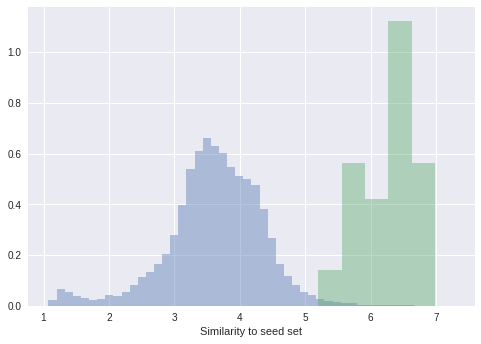

In [13]:
expand, expand_idx, sim_2_seed, fig = expand_seed(
    seed,
    sim,
    sim_names,
    agg='mean',
    min_sim=4,
    filter_perc=None,
    seed_perc=0,
    agg_perc=None,
    expand_size=None,
    figure=True,
)
expand = list(expand)
len(expand)

# Run CLIXO

In [14]:
df_sq = pd.DataFrame(sim[expand_idx, :][:, expand_idx], index=expand, columns=expand)
df = melt_square(df_sq)

In [15]:
ont = Ontology.run_clixo(df, alpha, beta)
# ont.propagate_annotations(direction='forward', inplace=True)

temp output: /tmp/tmpyxqmrH
temp graph: /tmp/tmpeTgHB8
temp output log: /tmp/tmpENy1V4
/tmp/tmpeTgHB8	0.1	0.5	-10000000 2017-08-09 14:41:27.888110
CLIXO command: /cellar/users/mikeyu/DeepTranslate/ddot/ddot/mhk7-clixo_0.3-cec3674/clixo /tmp/tmpeTgHB8 0.1 0.5 | awk '{if ( $1 ~ /^#/ ) {print "\#", strftime("%Y-%m-%d %H:%M:%S"), $0 ; fflush() } else {print $0}}' | tee /tmp/tmpENy1V4
Extracting by grep -v # 2017-08-09 14:41:29.195860
Elapsed time (sec): 1.31485795975 2017-08-09 14:41:29.223603
Ontology: 246 genes, 38 terms, 290 gene-term relations, 38 term-term relations


In [88]:
# ont.to_3col_table('/cellar/users/mikeyu/tmp.txt')
ont = Ontology.from_table('/cellar/users/mikeyu/tmp.txt')

# Align with Gene Ontology

## Read Gene Ontology from NDEx

In [8]:
go_human = Ontology.from_ndex(go_uuid)
go_human.summary()

'18765 genes, 19211 terms, 260093 gene-term relations, 43410 term-term relations'

In [89]:
go_human = Ontology.from_table('/cellar/users/mikeyu/go.txt')

In [90]:
term_descriptions = read_term_descriptions('/cellar/users/mikeyu/DeepTranslate/go_human_7jun2017/goID_2_name.tab')
go_human.update_node_attr(term_descriptions.to_frame())

## Do alignment

In [ ]:
alignment = ont.align(go_human, 3, 4, update_self=True, update_ref=True)
alignment.head()

In [85]:
import os, shutil
import shlex
from subprocess import Popen
from ddot import read_alignment_file
import tempfile

def align_hierarchies(hier1,
                      hier2,
                      iterations,
                      threads,
                      update_hier1=False,
                      update_hier2=False,
                      calculateFDRs=None,
                      mutual_collapse=True,
                      output=None):
    if output is None:
        with tempfile.NamedTemporaryFile('w', delete=True) as output_file:
            return align_hierarchies(hier1, hier2, iterations, threads,
                                     update_hier1=update_hier1, update_hier2=update_hier2,
                                     mutual_collapse=mutual_collapse,
                                     output=output_file.name,
                                     calculateFDRs=calculateFDRs)

    hier1_orig, hier2_orig = hier1, hier2
    if mutual_collapse:
        hier1, hier2 = Ontology.mutual_collapse(hier1, hier2)

    def to_file(hier):
        if isinstance(hier, Ontology):
            with tempfile.NamedTemporaryFile('w', delete=False) as f:
                hier.to_3col_table(f, parent_child=True)
            hier = f.name
        else:
            assert isinstance(hier, file) or os.path.exists(hier)
        return hier

    hier1 = to_file(hier1)
    hier2 = to_file(hier2)

    if calculateFDRs is None:
        assert os.path.isdir(ddot.config.alignOntology)
        calculateFDRs = os.path.join(ddot.config.alignOntology, 'calculateFDRs')
    assert os.path.isfile(calculateFDRs)

    output_dir = tempfile.mkdtemp(prefix='tmp')
    cmd = '{5} {0} {1} 0.05 criss_cross {2} {3} {4} gene'.format(
              hier1, hier2, output_dir, iterations, threads, calculateFDRs)
    print 'Alignment command:', cmd

    p = Popen(shlex.split(cmd), shell=False)
    
    try:        
        p.wait()
        shutil.copy(os.path.join(output_dir, 'alignments_FDR_0.1_t_0.1'), output)
    finally:
        if os.path.isdir(output_dir):
            shutil.rmtree(output_dir)

        if p.poll() is None:
            if verbose: time_print('Killing alignment process %s. Output: %s' % (p.pid, output))
            p.kill()  # Kill the process

        alignment = read_alignment_file(output)

        append_prefix = lambda x: 'Aligned_%s' % x
        
        if update_hier1:
            tmp = alignment.copy()[['Term', 'Similarity', 'FDR']]
            overlap = pd.Index(tmp['Term']).intersection(hier2_orig.node_attr.index)
            other_attr = hier2_orig.node_attr.loc[overlap, :].rename(columns=append_prefix)
            tmp.rename(columns=append_prefix, inplace=True)
            print tmp.head()
            hier1_orig.update_node_attr(tmp)            
#             hier1_orig.update_node_attr(other_attr)
        if update_hier2:
            tmp = alignment.copy()[['Term', 'Similarity', 'FDR']]
            print tmp['Term']
            tmp.index, tmp['Term'] = tmp['Term'].values.copy(), tmp.index.values.copy()
            overlap = pd.Index(tmp['Term']).intersection(hier1_orig.node_attr.index)
            other_attr = hier1_orig.node_attr.loc[overlap, :].rename(columns=append_prefix)
            tmp.rename(columns=lambda x: 'Aligned_%s' % x, inplace=True)
            print tmp.head()
            hier2_orig.update_node_attr(tmp)
#             hier2_orig.update_node_attr(other_attr)

        return alignment

In [91]:
alignment = align_hierarchies(ont, go_human, 3, 4, update_hier1=True, update_hier2=True)

collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpO_yLw3
collapse command: /cellar/users/mikeyu/alignOntology/collapseRedundantNodes /tmp/tmpK9LvNW
Alignment command: /cellar/users/mikeyu/alignOntology/calculateFDRs /tmp/tmp_bcoFn /tmp/tmphxPCJi 0.05 criss_cross /tmp/tmpEq9iOp 3 4 gene
          Aligned_Term  Aligned_Similarity  Aligned_FDR
Term                                                   
CLIXO:254   GO:0005849            0.903591          0.0
CLIXO:256   GO:0000811            0.892705          0.0
CLIXO:265   GO:0005662            0.892473          0.0
CLIXO:251   GO:0005971            0.884841          0.0
CLIXO:268   GO:0009378            0.879401          0.0
Term
CLIXO:254    GO:0005849
CLIXO:256    GO:0000811
CLIXO:265    GO:0005662
CLIXO:251    GO:0005971
CLIXO:268    GO:0009378
CLIXO:272    GO:0097472
CLIXO:269    GO:0071140
CLIXO:271    GO:0034719
CLIXO:273    GO:0003725
CLIXO:266    GO:0036464
CLIXO:276    GO:1990391
CLIXO:277    GO:00

In [93]:
ont.node_attr

,Aligned_Term,Aligned_Similarity,Aligned_FDR
Term,,,
CLIXO:254,GO:0005849,0.903591,0.0
CLIXO:256,GO:0000811,0.892705,0.0
CLIXO:265,GO:0005662,0.892473,0.0
CLIXO:251,GO:0005971,0.884841,0.0
CLIXO:268,GO:0009378,0.879401,0.0
CLIXO:272,GO:0097472,0.516281,0.0
CLIXO:269,GO:0071140,0.459495,0.0
CLIXO:271,GO:0034719,0.448419,0.0
CLIXO:273,GO:0003725,0.441528,0.0


In [92]:
go_human.node_attr

,Term_Description,Aligned_Term,Aligned_Similarity,Aligned_FDR
GO:0005849,mRNA cleavage factor complex,CLIXO:254,0.903591,0.0
GO:0000811,GINS complex,CLIXO:256,0.892705,0.0
GO:0005662,DNA replication factor A complex,CLIXO:265,0.892473,0.0
GO:0005971,ribonucleoside-diphosphate reductase complex,CLIXO:251,0.884841,0.0
GO:0009378,four-way junction helicase activity,CLIXO:268,0.879401,0.0
GO:0097472,cyclin-dependent protein kinase activity,CLIXO:272,0.516281,0.0
GO:0071140,resolution of mitotic recombination intermediates,CLIXO:269,0.459495,0.0
GO:0034719,SMN-Sm protein complex,CLIXO:271,0.448419,0.0
GO:0003725,double-stranded RNA binding,CLIXO:273,0.441528,0.0
GO:0036464,cytoplasmic ribonucleoprotein granule,CLIXO:266,0.438152,0.0


In [35]:
alignment.to_csv('/cellar/users/mikeyu/alignment.txt', index=True, sep='\t')

In [36]:
alignment = pd.read_table('/cellar/users/mikeyu/alignment.txt', index_col=0)
alignment = alignment.rename(columns={'Term.1' : 'Term'})

# Upload to NDEx

## Upload subnetworks supporting each term

In [37]:
name = 'FanGO'
description = (
    'Data-driven ontology created by CLIXO '
    '(parameters: alpha={alpha}, beta={beta}). '
    'Created from similarity network '
    'at {ndex_server}/{ndex_uuid}').format(
        alpha=alpha,
        beta=beta,
        ndex_server=ndex_server,
        ndex_uuid=similarity_uuid)

In [38]:
term_2_uuid = ont.upload_subnets_ndex(
    df,
    ['similarity'],
    ndex_server,
    ndex_user,
    ndex_pass,
    name,
    public=True,
    verbose=True
)

features: ['similarity']
gene_columns: ['Gene1', 'Gene2']
Setup time: 0.0638768672943
(0, 'Term:', 'CLIXO:246', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1582, 'Upload time:', 0.1575)
(1, 'Term:', 'CLIXO:247', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1643, 'Upload time:', 0.1629)
(2, 'Term:', 'CLIXO:248', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1633, 'Upload time:', 0.161)
(3, 'Term:', 'CLIXO:249', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1613, 'Upload time:', 0.1592)
(4, 'Term:', 'CLIXO:250', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1566, 'Upload time:', 0.1545)
(5, 'Term:', 'CLIXO:251', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1625, 'Upload time:', 0.1605)
(6, 'Term:', 'CLIXO:252', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1566, 'Upload time:', 0.1556)
(7, 'Term:', 'CLIXO:253', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1614, 'Upload time:', 0.1592)
(8, 'Term:', 'CLIXO:254', 'Gene pairs:', 1, 'Genes:', 2, 'Time:', 0.1608, 'Upload time:', 0.1583)
(9, 'Term:', 'CLIXO:255', 'Gene p

In [42]:
import cPickle
with open('/cellar/users/mikeyu/term_2_uuid.pkl', 'w') as f:
    cPickle.dump(term_2_uuid, f)

In [ ]:
import cPickle
with open('/cellar/users/mikeyu/term_2_uuid.pkl', 'w') as f:
    term_2_uuid = cPickle.load(f)

## Upload ontology

In [44]:
ont_ndex = ont.to_NdexGraph(
    name=name,
    description=description,
    term_2_uuid=term_2_uuid,
    layout='bubble',
    alignment=alignment,
    represents=True)

for x, n in ont_ndex.nodes(data=True):
    n['x_pos'] = float(n['x_pos'])
    n['y_pos'] = float(n['y_pos'])
    if n.has_key('Aligned_Term'):
        print x, n['Aligned_Term']
        
nx.write_graphml(ont_ndex, '/cellar/users/mikeyu/tmp.graphml')

29 GO:0005662
82 GO:0006298
118 GO:0034719
188 GO:1902494
190 GO:0009611
191 GO:0031436
192 GO:0006303
196 GO:0003725
197 GO:0097472
216 GO:0009378
220 GO:0071140
231 GO:0036464


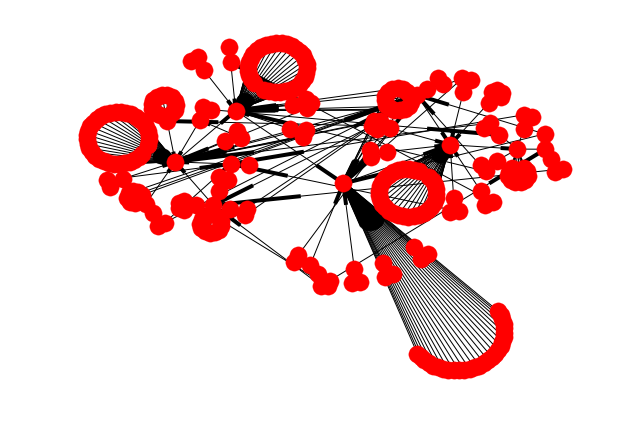

In [20]:
# ont_nx = ont.to_networkx(layout='bubble', spanning_tree=True)
# ont_nx.pos = transform_pos(ont_nx.pos)
# nx.draw(ont_nx, ont_nx.pos)
# nx.write_graphml(ont_nx, '/cellar/users/mikeyu/tmp.graphml')

In [46]:
ont_url = ont_ndex.upload_to(ndex_server, ndex_user, ndex_pass)
ont_uuid = parse_ndex_uuid(ont_url)
ont_url

import time
time.sleep(0.5)
import ndex.client as nc
ndex = nc.Ndex(ndex_server, ndex_user, ndex_pass)
ndex.make_network_public(ont_uuid)

''